##  Рекомендательная система подбора недвижимости

In [1]:
#Подключаю все необходимые библиотеки

from bs4 import BeautifulSoup
import requests
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker
import seaborn as sns
import numpy as np
import matplotlib.mlab as mlab
import matplotlib
plt.style.use('ggplot')
from matplotlib.pyplot import figure
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (12,8)
pd.options.mode.chained_assignment = None

## 1. Парсинг и обработка данных

##### 1.1 Парсинг сайта ЕГСН

In [ ]:
#Парсер сайта ЕГСН, для получения актуальной информации о стоимости квартир в Москве
data = []
for i in range(1,2306,1):
    url = 'https://www.egsnk.ru/kvartiry/kupit/p'
    url = url + str(i)
    page = requests.get(url)
    if page.status_code != 200:
        print(page.status_code)
        exit()
    soup = BeautifulSoup(page.text, features="html.parser")
    flats = soup.find_all('div', class_='res_row clearfix')  
    for flat in flats:
        block_01 = flat.find('div', class_='res_right')
        block_02_01 = flat.find_all('div', class_='mt8')
        block_02_02 = block_02_01[0]
        block_03 = flat.find('div', class_='res_text fs15')
        block_03_02 = block_03.find_all('div')
        block_03_03 = block_03_02[0]
            
        text_01 = block_01.text.strip().replace('\n', '\t')
        cost = float(''.join([x for x in text_01 if x.isdigit() or x == '.']))
        description = block_03_03.text.strip().replace('\n', '\t')
        info = block_03.text.strip().replace('\n', '\t')
        address = block_02_02.text.strip().replace('\n', '\t')

        data.append({
                'cost': cost,
                'address': address,
                'description': description,
                'all_info': info,
            })
df = pd.DataFrame(data).to_csv('data_all.csv')

##### 1.2 Обработка полученных данных

In [ ]:
flat =pd.read_csv('E:\project university\Выпускная работа\DataSet\Недвижка\my_DS\data_all.csv')
flat[['rooms', 'square','floor1']] = flat['description']. str.split('|', 0 , expand= True )# разделяю значения по столбцам
flat['all_info'] =flat.apply(lambda x: x['all_info'].replace(x['address'],''), axis=1) # удаляю из all_info ифу по address
flat['all_info'] =flat.apply(lambda x: x['all_info'].replace(x['description'],''), axis=1) # удаляю из all_info ифу по description
flat = flat.drop(columns='description') #удаляю колонку старого дескрипшина
flat[['des_property']] = flat['all_info'].str.extract('(?:(?<=пешком)|(?<=транспортом))(.*)', 0, expand= True) #добавляю новый дескрипшн
flat.des_property.fillna(flat.all_info, inplace=True) # копирую описание из all_info в ячейки NAN
flat['all_info'] =flat.apply(lambda x: x['all_info'].replace(x['des_property'],''), axis=1) # удаляю из all_info ифу по property и получаю метро
flat.rename(columns={'all_info': 'metro','des_property': 'description'},inplace = True )# переименовываю столбцы
flat = flat.drop(columns='Unnamed: 0') 
flat['cost_for_meter(₽)'] =((flat['cost'])/(flat['square'].str.extract(r'(.*(?=\м²))', expand=False).astype("float"))).astype("float") # получаю еще один столбец с ценой квадратного метра
flat['cost_for_meter(₽)'] = round(flat['cost_for_meter(₽)'],1) #округляю до десятых
flat['cost']=flat['cost'].astype("int") 
flat.rename(columns={'cost': 'cost(₽)'},inplace = True )# переименовываю столбцы
                                                  # Перевожу пешком и на транспорте в метры от метро и очищаю от букв
flat[['metro_name', 'min']] = flat['metro'].str.split(',' , 1 , expand = True)# Отделяю минуты и название метро
flat['metro_name'] = flat['metro_name'].str.lower()# Перевод названий станций в нижний регистр
flat['min_int'] =flat['min'].str.extract(r'(\d+(?= \мин.))').fillna(0) #Выделяю только цифры
flat['min_int'] =flat['min_int'].astype("int")#перевожу в INT
flat['alpha'] = flat['min'].str.contains('пешком') # нахожу слова -пешком истина -есть ложь нет
flat['alpha']=flat['alpha'].replace({False:333,	True:84}).fillna(0).astype("int") # меняю ложь на 333 м/мин (20км/ч) и истину на 84 м/мин(5км/ч), и перевожу в INT
flat['distance(м)']= flat['alpha']*flat['min_int'] # перемножаю минуты на скорость получаю метры до метро
flat['distance(м)']=flat['distance(м)'].astype("float") # перевожу расстояние до метро в тип флоат
flat[['floor2']] = flat['floor1'].str.extract('(?:(?<=этаж))(.*)', 0, expand= True)# удаляю слово этаж
flat[['floor','floors']] = flat['floor2'].str.split('/', 0 , expand= True )# разделяю значения этажей по столбцам
flat['floor']=flat['floor'].astype("int") # перевожу этаж в тип INT
flat['floors']=flat['floors'].astype("int") # перевожу этажи в тип INT
flat[['square(м²)','DEL']] = flat['square'].str.split('м', 0 , expand= True ) # удаляю ненужные м²
flat['square(м²)']=flat['square(м²)'].astype("float")# перевожу площадь в тип флоат
flat = flat.drop(['alpha','min_int','min','metro','floor1','floor2','square','DEL'],axis=1) # удаляю промежуточные столбцы для вычислений
flat = flat[['rooms','cost(₽)','square(м²)','cost_for_meter(₽)','address','metro_name','distance(м)','floor','floors','description']]#порядок столбцов
#Удаляю строки с неверными данными
flat=flat.drop(axis=1, index=31397)
flat=flat.drop(axis=1, index=31401)
flat=flat.drop(axis=1, index=646)
flat.to_csv('E:\project university\Выпускная работа\DataSet\Недвижка\my_DS\moscow_flat22.csv', index=False)
flat.head(5)

In [5]:
flat.head(5)

,rooms,cost(₽),square(м²),cost_for_meter(₽),address,metro_name,distance(м),floor,floors,description
0,1 – комнатная,5000000,31.0,161290.3,"Центральная ул., 6",бульвар дмитрия донского,4995.0,2,4,Прекрасная однокомнатная квартира в доме с лиф...
1,1 комната,4500000,98.0,45918.4,"Коптевская ул., 28к2",коптево,420.0,3,5,"Светлая, просторная комната 19 кв. метров. Отд..."
2,1 – комнатная,10900000,36.1,301939.1,"15-я Парковая ул., 1/123 корп.2",измайловская,1680.0,1,9,"Первомайская, 15 мин. пешкомТёплая уютная квар..."
3,1 комната,3650000,93.0,39247.3,"Матросская Тишина ул., 23/7",сокольники,1428.0,4,5,"в шаговой доступности парк Сокольники. , Разви..."
4,доля (1/2),1200000,72.3,16597.5,"Центральная ул., 6",NaN,0.0,1,2,Ильинское с.Все коммуникации центральные.Кварт...


##### 1.3 Обработка данных скачанных из Kaggle

In [ ]:
#Обработка данных из Kaggle
flat_full =pd.read_csv('moscow_full_2.0.csv')
flat_full[['rooms', 'square','floor1']] = flat_full['title']. str.split(', ', 0 , expand= True )# разделяю значения по столбцам
flat_full.rename(columns = {'adress' : 'address'}, inplace = True) # меняю наименование на корректное
flat_full = flat_full.drop(columns='title') #удаляю колонку старого title
flat_full[['floor2','floor3']] = flat_full['floor1'].str.split('э', 0 , expand= True ) # разделяю floor1 значения по столбцам
flat_full[['floor', 'floors']] = flat_full['floor2']. str.split('/', 0 , expand= True ).fillna(0)# разделяю floor2 значения по столбцам
flat_full['floor']=flat_full['floor'].astype("int") # перевожу этаж в тип INT
flat_full['floors']=flat_full['floors'].astype("int") # перевожу этажи в тип INT
flat_full[['square(м²)','DEL']] = flat_full['square'].str.split('м', 0 , expand= True ) # удаляю ненужные м²
flat_full['square(м²)']=flat_full['square(м²)'].astype("float")# перевожу площадь в тип флоат
                               # Очищаю cost_for_meter(₽)
flat_full[['cost_for_meter(₽)', 'DEL1']] = flat_full['cost_for_meter']. str.split(' ₽ ', 0 , expand= True )# разделяю значения по столбцам
flat_full['cost_for_meter(₽)']=flat_full['cost_for_meter(₽)'].fillna(0)# меняю нан на 0
mask = flat_full['cost_for_meter(₽)'].str.fullmatch(r'[\d ]*')# ввожу переменную с регулярным выражением
flat_full.loc[mask, 'cost_for_meter(₽)'] = flat_full.loc[mask, 'cost_for_meter(₽)'].str.replace(' ', '')# меняю replace ом пробел
flat_full['cost_for_meter(₽)']=flat_full['cost_for_meter(₽)'].astype("int")# перевожу в флоат
flat_full['cost_for_meter(₽)'] = (flat_full['cost_for_meter(₽)'] + ((flat_full['cost_for_meter(₽)'])*(34/100)))
                               # Очищаю cost
flat_full[['cost(₽)', 'DEL2']] = flat_full['cost']. str.split('₽', 0 , expand= True )# разделяю значения по столбцам
flat_full['cost(₽)']=flat_full['cost(₽)'].fillna(0)# меняю нан на 0
mask = flat_full['cost(₽)'].str.fullmatch(r'[\d ]*')# ввожу переменную с регулярным выражением
flat_full.loc[mask, 'cost(₽)'] = flat_full.loc[mask, 'cost(₽)'].str.replace(' ', '')# меняю replace ом пробел
flat_full['cost(₽)']=flat_full['cost(₽)'].astype("float")# перевожу в float
flat_full['cost(₽)'] = (flat_full['cost(₽)'] + ((flat_full['cost(₽)'])*0.34)) # увеличиваю на 34%
                                # Получаю расстояние в метрах
flat_full['min_int']= flat_full['metro'].str.extract(r'([-+]?(?:\d+(?:\.\d*)?|\.\d+))(?= м| км)').fillna(0) #Выделяю только цифры
flat_full['min_int']=flat_full['min_int'].astype("float")# перевожу в INT
flat_full['alpha1'] = flat_full['metro'].str.contains(' км') # нахожу слова -км истина -есть ложь нет
flat_full['alpha1']=flat_full['alpha1'].replace({False:1,	True:1000}).fillna(0).astype("int") # меняю ложь на 1  и истину на 1000 (в 1 км =1000м), и перевожу в INT
flat_full['distance(м)']= flat_full['alpha1']*flat_full['min_int']  # получаю расстояние от метров метрах
                                # выделяю название метро
flat_full['metro_name']= flat_full['metro'].str.extract(r'(.*(?= \d))') # выделяю название метро
flat_full ['metro_name'] = flat_full ['metro_name'].str.lower()# перевод названий станций в нижний регистр
                                # удаляю промежуточные колонки
flat_full = flat_full.drop(['floor3','floor2','floor1','DEL','square', 'cost_for_meter', 'DEL1','cost','DEL2','min_int','alpha1','metro'],axis=1)  #удаляю промежуточные колонки
flat_full= flat_full[['rooms','cost(₽)','square(м²)','cost_for_meter(₽)','address','metro_name','distance(м)','floor','floors','description']]#порядок столбцов
flat_full.to_csv('moscow_flat20.csv',index=False)
flat_full.head(5)

In [3]:
flat_full.head(5)

,rooms,cost(₽),square(м²),cost_for_meter(₽),address,metro_name,distance(м),floor,floors,description
0,Квартира своб. планировки,50920000.00,130.00,391692.72,"Москва, 3-я улица Ямского Поля, 9к3",белорусская,407.0,5,5,Представляю Вашему вниманию 2-х уровневый пент...
1,2-комн. квартира,62980000.00,93.00,677203.84,"Москва, Ленинградский проспект, 36с31",динамо,612.0,6,10,В премиальном ЖК Hyatt Regency предлагаем Ваше...
2,1-комн. квартира,11792000.00,36.00,327554.96,"Москва, Печорская улица, 5",бабушкинская,792.0,5,16,"Свободная продажа, никто не прописан. В кварти..."
3,1-комн. квартира,11806521.58,47.59,248088.94,пр-т Нахимовский,профсоюзная,1400.0,0,0,Многофункциональный комплекс «Нахимов» предста...
4,1-комн. квартира,15678000.00,36.00,435500.00,"Москва, Новорогожская улица, 11к2",римская,446.0,6,12,Собственник. Риелторов и прочих помогателей ПР...


##### 1.4 Поиск и удаление дубликатов

In [17]:
flat =pd.read_csv(r'C:\Users\Daniel\project university\Выпускная работа\DataSet\Недвижка\my_DS\moscow_flat22.csv')
flat_full=pd.read_csv(r'C:\Users\Daniel\project university\Выпускная работа\DataSet\Недвижка\my_DS\moscow_flat20.csv')

In [18]:
duplicate_flat22 = flat[flat.duplicated ()]
duplicate_flat20 = flat_full[flat_full.duplicated ()]

In [19]:
duplicate_flat22.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11485 entries, 1425 to 44845
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   rooms              11485 non-null  object 
 1   cost(₽)            11485 non-null  int64  
 2   square(м²)         11485 non-null  float64
 3   cost_for_meter(₽)  11485 non-null  float64
 4   address            11485 non-null  object 
 5   metro_name         6004 non-null   object 
 6   distance(м)        11485 non-null  float64
 7   floor              11485 non-null  int64  
 8   floors             11485 non-null  int64  
 9   description        11438 non-null  object 
dtypes: float64(3), int64(3), object(4)
memory usage: 987.0+ KB


In [20]:
duplicate_flat20.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 533 entries, 1299 to 55662
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   rooms              533 non-null    object 
 1   cost(₽)            533 non-null    float64
 2   square(м²)         533 non-null    float64
 3   cost_for_meter(₽)  533 non-null    float64
 4   address            530 non-null    object 
 5   metro_name         457 non-null    object 
 6   distance(м)        533 non-null    float64
 7   floor              533 non-null    int64  
 8   floors             533 non-null    int64  
 9   description        533 non-null    object 
dtypes: float64(4), int64(2), object(4)
memory usage: 45.8+ KB


In [21]:
flat = flat.drop_duplicates()
flat_full = flat_full.drop_duplicates()

##### 1.5 Объединение датафреймов

In [22]:
# Слияние датасетов
frames = [flat, flat_full]
result = pd.concat(frames)
result.to_csv(r'C:\Users\Daniel\project university\Выпускная работа\Realty.csv',index=False) 

In [23]:
result.head(5)

,rooms,cost(₽),square(м²),cost_for_meter(₽),address,metro_name,distance(м),floor,floors,description
0,1 – комнатная,5000000.0,31.0,161290.3,"Центральная ул., 6",бульвар дмитрия донского,4995.0,2,4,Прекрасная однокомнатная квартира в доме с лиф...
1,1 комната,4500000.0,98.0,45918.4,"Коптевская ул., 28к2",коптево,420.0,3,5,"Светлая, просторная комната 19 кв. метров. Отд..."
2,1 – комнатная,10900000.0,36.1,301939.1,"15-я Парковая ул., 1/123 корп.2",измайловская,1680.0,1,9,"Первомайская, 15 мин. пешкомТёплая уютная квар..."
3,1 комната,3650000.0,93.0,39247.3,"Матросская Тишина ул., 23/7",сокольники,1428.0,4,5,"в шаговой доступности парк Сокольники. , Разви..."
4,доля (1/2),1200000.0,72.3,16597.5,"Центральная ул., 6",NaN,0.0,1,2,Ильинское с.Все коммуникации центральные.Кварт...


##### 1.6 Проверка полученных данных (ядерная оценка плотности)

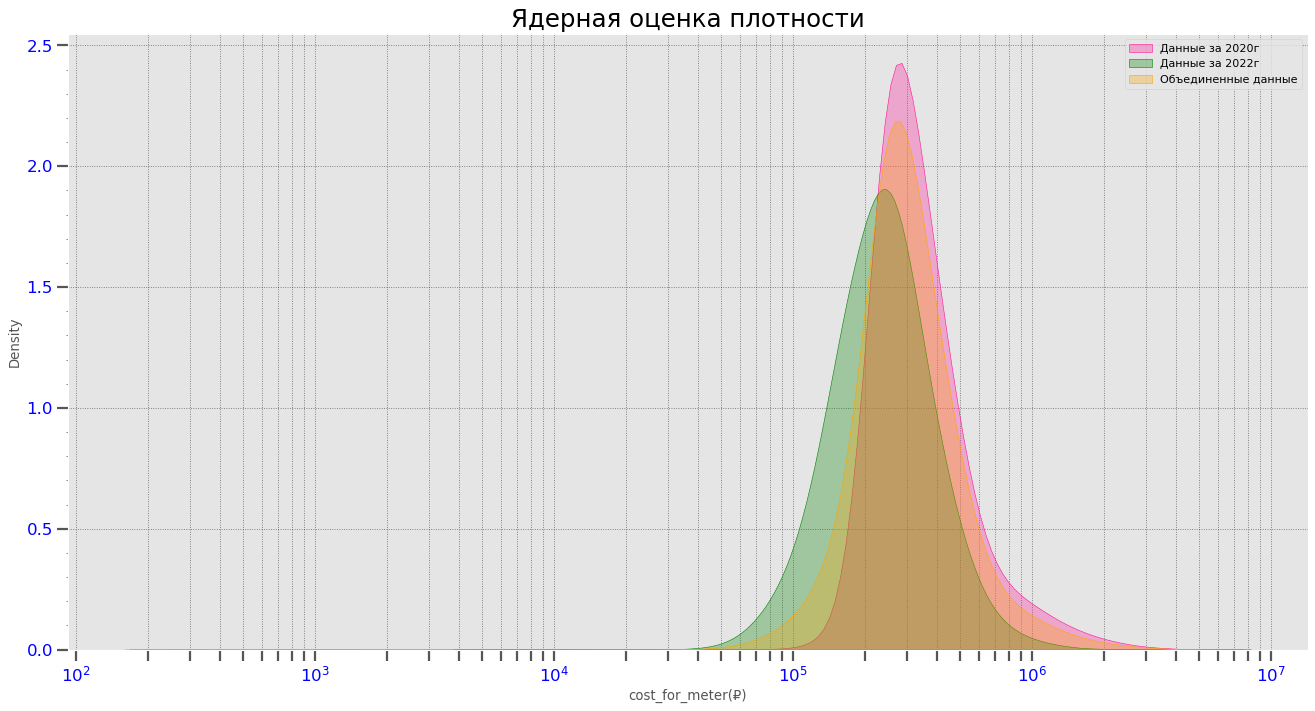

In [26]:
#Распределение случайной величины

#создание области графика
plt.figure(figsize=(20,10), dpi=80)
#считывание файлов csv
flat_total= pd.read_csv(r'C:\Users\Daniel\project university\Выпускная работа\Realty.csv')
flat_22 = pd.read_csv(r'C:\Users\Daniel\project university\Выпускная работа\DataSet\Недвижка\my_DS\moscow_flat22.csv')
flat_20 = pd.read_csv(r'C:\Users\Daniel\project university\Выпускная работа\DataSet\Недвижка\my_DS\moscow_flat20.csv')
#построение распределений
sns.kdeplot(flat_20['cost_for_meter(₽)'],log_scale=True,shade=True,bw_method=0.4,color="deeppink", label="Данные за 2020г", alpha=.3)
sns.kdeplot(flat_22['cost_for_meter(₽)'],log_scale=True,shade=True,bw_method=0.4,color="g", label="Данные за 2022г", alpha=.3)
sns.kdeplot(flat_total['cost_for_meter(₽)'],log_scale=True,shade=True,bw_method=0.4,color="orange", label="Объединенные данные", alpha=.3)
#управление настройками сетки
plt.grid(axis='x',which='both', linestyle=':',color="black",alpha=.5)
plt.grid(axis='y',which='major', linestyle=':',color="black",alpha=.5)
#надписи координатных осей
plt.minorticks_on()
#plt.xlabel('Стоимость за м²(в логарифмическом масштабе)', fontsize=16)
#plt.ylabel('Плотность', fontsize=16)
plt.tick_params(axis='x',which='both', length=10, width=2)
plt.tick_params(axis='y',which='major', length=10, width=2)
plt.xticks(color="b", size=15)
plt.yticks(color="b", size=15)
#титул, легенда 
plt.title('Ядерная оценка плотности', fontsize=22)
plt.legend()
#обновление графика вне интер-актива
plt.show()


##### 1.7 Добавляю параметр-"расстояние от центра" до указанного метро (лобное место - условно центр)

In [ ]:
#Парсер удаленности метро от центра


#  список данных
data = []
# без цикла
page = requests.get('https://m.101hotels.com/recreation/russia/moskva/infrastructure/metro?ysclid=la3a4g68is638416669&page=23')
# проверка статуса страниц 
if page.status_code != 200:
    print(page.status_code)
    exit()
# индексация информации по выбранным тегам в блоки
soup = BeautifulSoup(page.text, features="html.parser")
metros = soup.find_all('li', class_='tiled_list_item')  
for metro in metros:
    block_01 = metro.find('div', class_='link__title')
    block_02 = metro.find('div', class_='center-distance')
# перевод блоков в строки и обработка строк
    name = block_01.text.strip().replace('\n', '\t')
    center_distance = block_02.text.strip().replace('\n', '\t')
# добавление в список данных
    data.append({
      'metro_name': name,
      'center_distance': center_distance,
            })
# выходной выйл
df = pd.DataFrame(data).to_csv('metro.csv',index=False)
# Обработка данных
metro =pd.read_csv('metro.csv')
#Выделяю только цифры
metro['center_distance']= metro['center_distance'].str.extract(r'([-+]?(?:\d+(?:\.\d*)?|\.\d+))(?= км)').fillna(0)
# перевожу расстояние до метро в метры, тип флоат
metro['center_distance/m']=(metro['center_distance'].astype("float"))*1000
# Перевод названий станций в нижний регистр
metro['metro_name'] = metro['metro_name'].str.lower()
#Удаляю столбец center_distance
metro = metro.drop(['center_distance'],axis=1) 
# выходной выйл
metro.to_csv('metro.csv',index=False)

In [6]:
metro.head(5)

,metro_name,center_distance/m
0,театральная,600.0
1,чеховская,1500.0
2,охотный ряд,500.0
3,тверская,1500.0
4,площадь революции,400.0


In [27]:
#Объединение по 'metro_name'
#считывание файлов csv
Realty = pd.read_csv(r'C:\Users\Daniel\project university\Выпускная работа\Realty.csv')
metro = pd.read_csv(r'C:\Users\Daniel\project university\Выпускная работа\DataSet\метро\metro.csv') 
df = Realty.merge(metro, how="left")#объединение файлов csv по 'metro_name' 
df['id'] = df.index
df = df[['id','rooms','cost(₽)','square(м²)','cost_for_meter(₽)','address','metro_name','distance(м)','center_distance/m','floor','floors','description']]#порядок столбцов
df.to_csv(r'C:\Users\Daniel\project university\Выпускная работа\DataSet\метро\df.csv',index=False)

In [28]:
df.head(5)

,id,rooms,cost(₽),square(м²),cost_for_meter(₽),address,metro_name,distance(м),center_distance/m,floor,floors,description
0,0,1 – комнатная,5000000.0,31.0,161290.3,"Центральная ул., 6",бульвар дмитрия донского,4995.0,20600.0,2,4,Прекрасная однокомнатная квартира в доме с лиф...
1,1,1 комната,4500000.0,98.0,45918.4,"Коптевская ул., 28к2",коптево,420.0,11400.0,3,5,"Светлая, просторная комната 19 кв. метров. Отд..."
2,2,1 – комнатная,10900000.0,36.1,301939.1,"15-я Парковая ул., 1/123 корп.2",измайловская,1680.0,10700.0,1,9,"Первомайская, 15 мин. пешкомТёплая уютная квар..."
3,3,1 комната,3650000.0,93.0,39247.3,"Матросская Тишина ул., 23/7",сокольники,1428.0,5400.0,4,5,"в шаговой доступности парк Сокольники. , Разви..."
4,4,доля (1/2),1200000.0,72.3,16597.5,"Центральная ул., 6",NaN,0.0,NaN,1,2,Ильинское с.Все коммуникации центральные.Кварт...


In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 88715 entries, 0 to 88714
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 88715 non-null  int64  
 1   rooms              88715 non-null  object 
 2   cost(₽)            88715 non-null  float64
 3   square(м²)         88715 non-null  float64
 4   cost_for_meter(₽)  88715 non-null  float64
 5   address            88402 non-null  object 
 6   metro_name         76264 non-null  object 
 7   distance(м)        88715 non-null  float64
 8   center_distance/m  60216 non-null  float64
 9   floor              88715 non-null  int64  
 10  floors             88715 non-null  int64  
 11  description        88621 non-null  object 
dtypes: float64(5), int64(3), object(4)
memory usage: 8.8+ MB


# 2. Предобработка данных

##### 2.1 Нахожу и заполняю пропущенные данные

In [30]:
# чтение данных
df = pd.read_csv(r'C:\Users\Daniel\project university\Выпускная работа\DataSet\метро\df.csv')
# shape and data types of the data
print(df.shape)
print(df.dtypes)

# отбор числовых колонок
df_numeric = df.select_dtypes(include=[np.number])
numeric_cols = df_numeric.columns.values
print(numeric_cols)

# отбор нечисловых колонок
df_non_numeric = df.select_dtypes(exclude=[np.number])
non_numeric_cols = df_non_numeric.columns.values
print(non_numeric_cols)

(88715, 12)
id                     int64
rooms                 object
cost(₽)              float64
square(м²)           float64
cost_for_meter(₽)    float64
address               object
metro_name            object
distance(м)          float64
center_distance/m    float64
floor                  int64
floors                 int64
description           object
dtype: object
['id' 'cost(₽)' 'square(м²)' 'cost_for_meter(₽)' 'distance(м)'
 'center_distance/m' 'floor' 'floors']
['rooms' 'address' 'metro_name' 'description']


<AxesSubplot:>

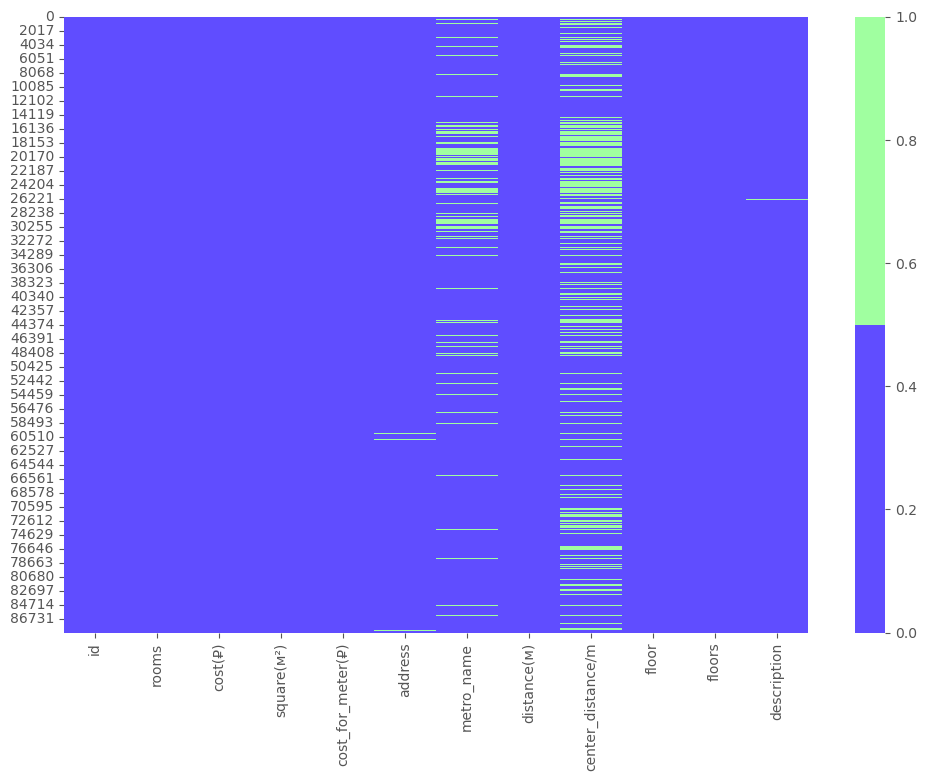

In [31]:
cols = df.columns[:30] # первые 30 колонок
# определяю цвета 
# салатовый - пропущенные данные, сиреневый - не пропущенные
colours = ['#604dff', '#a0ffa0'] 
sns.heatmap(df[cols].isnull(), cmap=sns.color_palette(colours))

In [32]:
#Замена пропущенных категориальных признаков на _MISSING_ и числовых на 0
df['metro_name'] = df['metro_name'].fillna('_MISSING_')
df['description'] = df['description'].fillna('_MISSING_')
df['address'] = df['address'].fillna('_MISSING_')
df['center_distance/m']=df['center_distance/m'].fillna(0)

In [33]:
#Проверка
for col in df.columns:
    pct_missing = np.mean(df[col].isnull())
    print('{} - {}%'.format(col, round(pct_missing*100)))
df.head(5)

id - 0%
rooms - 0%
cost(₽) - 0%
square(м²) - 0%
cost_for_meter(₽) - 0%
address - 0%
metro_name - 0%
distance(м) - 0%
center_distance/m - 0%
floor - 0%
floors - 0%
description - 0%


,id,rooms,cost(₽),square(м²),cost_for_meter(₽),address,metro_name,distance(м),center_distance/m,floor,floors,description
0,0,1 – комнатная,5000000.0,31.0,161290.3,"Центральная ул., 6",бульвар дмитрия донского,4995.0,20600.0,2,4,Прекрасная однокомнатная квартира в доме с лиф...
1,1,1 комната,4500000.0,98.0,45918.4,"Коптевская ул., 28к2",коптево,420.0,11400.0,3,5,"Светлая, просторная комната 19 кв. метров. Отд..."
2,2,1 – комнатная,10900000.0,36.1,301939.1,"15-я Парковая ул., 1/123 корп.2",измайловская,1680.0,10700.0,1,9,"Первомайская, 15 мин. пешкомТёплая уютная квар..."
3,3,1 комната,3650000.0,93.0,39247.3,"Матросская Тишина ул., 23/7",сокольники,1428.0,5400.0,4,5,"в шаговой доступности парк Сокольники. , Разви..."
4,4,доля (1/2),1200000.0,72.3,16597.5,"Центральная ул., 6",_MISSING_,0.0,0.0,1,2,Ильинское с.Все коммуникации центральные.Кварт...


##### 2.2 Нахожу и удаляю выбросы

<AxesSubplot:>

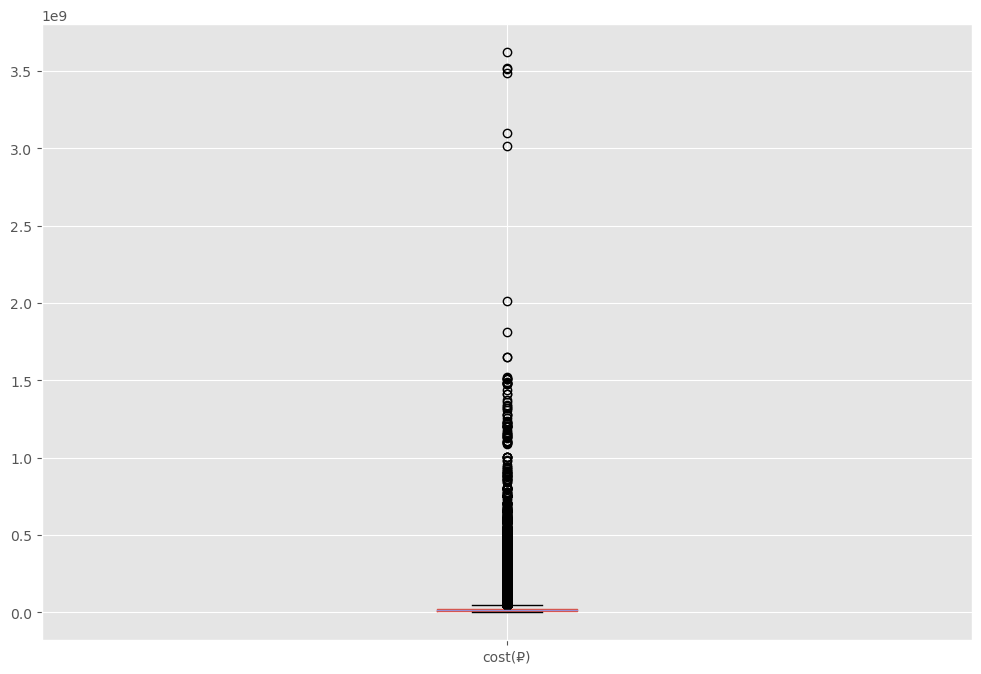

In [34]:
# Нахожу выбросы по цене
df.boxplot(column=['cost(₽)'])

In [35]:
# удаляю строки с выбросами
ind_missing = df[df['cost(₽)'] > 1600000000].index
df = df.drop(ind_missing, axis=0)

<AxesSubplot:>

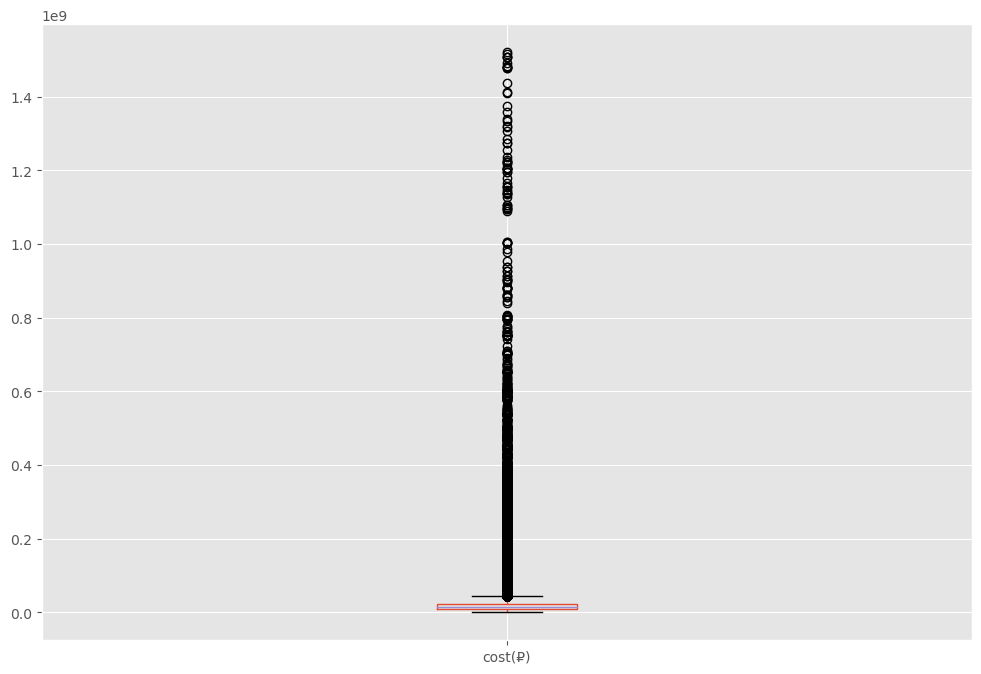

In [36]:
df.boxplot(column=['cost(₽)'])

In [38]:
df.to_csv(r'C:\Users\Daniel\project university\Выпускная работа\Сlean.csv',index=False)
df.head(5)

,id,rooms,cost(₽),square(м²),cost_for_meter(₽),address,metro_name,distance(м),center_distance/m,floor,floors,description
0,0,1 – комнатная,5000000.0,31.0,161290.3,"Центральная ул., 6",бульвар дмитрия донского,4995.0,20600.0,2,4,Прекрасная однокомнатная квартира в доме с лиф...
1,1,1 комната,4500000.0,98.0,45918.4,"Коптевская ул., 28к2",коптево,420.0,11400.0,3,5,"Светлая, просторная комната 19 кв. метров. Отд..."
2,2,1 – комнатная,10900000.0,36.1,301939.1,"15-я Парковая ул., 1/123 корп.2",измайловская,1680.0,10700.0,1,9,"Первомайская, 15 мин. пешкомТёплая уютная квар..."
3,3,1 комната,3650000.0,93.0,39247.3,"Матросская Тишина ул., 23/7",сокольники,1428.0,5400.0,4,5,"в шаговой доступности парк Сокольники. , Разви..."
4,4,доля (1/2),1200000.0,72.3,16597.5,"Центральная ул., 6",_MISSING_,0.0,0.0,1,2,Ильинское с.Все коммуникации центральные.Кварт...


##### 2.3 Предобработка столбца с описанием (description)

In [2]:
import re  # Для препроцессинга
import pandas as pd
from time import time  # Для определения времени операций
import spacy
from spacy.lang.ru.examples import sentences 
from collections import defaultdict  # Для частоты слов
import logging  # Настройка для gensim
logging.basicConfig(format="%(levelname)s - %(asctime)s: %(message)s", datefmt= '%H:%M:%S', level=logging.INFO)

In [3]:
# Считываю файл
data = pd.read_csv(r"C:\Users\Daniel\project university\Выпускная работа\Сlean.csv")
df=data['description']

In [4]:
df.head(-5)

0        Прекрасная однокомнатная квартира в доме с лиф...
1        Светлая, просторная комната 19 кв. метров. Отд...
2        Первомайская, 15 мин. пешкомТёплая уютная квар...
3        в шаговой доступности парк Сокольники. , Разви...
4        Ильинское с.Все коммуникации центральные.Кварт...
                               ...                        
88695    Переуступка, входит в цену, 2 корпус, комнаты ...
88696    Продается трехкомнатная квартира, замечательно...
88697    ПРОЧИТАЙТЕ ОБЪЯВЛЕНИЕ ПОЛНОСТЬЮ !!!Звонить СТР...
88698    Сначала читаем, потом звоним.)Согласно статье ...
88699    ПРОЧИТАЙТЕ ОБЪЯВЛЕНИЕ ПОЛНОСТЬЮ !!!Звонить СТР...
Name: description, Length: 88700, dtype: object

In [5]:
df.isnull().sum()

0

In [6]:
# Загружаю модель
!python -m spacy download ru_core_news_sm

     ---------------------------------------- 15.3/15.3 MB 1.8 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('ru_core_news_sm')


In [7]:
nlp = spacy.load('ru_core_news_sm', disable=['ner', 'parser']) # отключение распознавания именованных объектов для повышения скорости
def cleaning(doc):
    #Лемматизируется и удаляет стоп-слова
    # doc должен быть пространственным объектом Doc
    txt = [token.lemma_ for token in doc if not token.is_stop]
   
    # если предложение состоит всего из одного или двух слов,
    # польза от тренинга мала, поэтому
    if len(txt) > 2:
        return ' '.join(txt)

INFO - 01:37:48: Loading dictionaries from c:\Users\Daniel\anaconda3\lib\site-packages\pymorphy2_dicts_ru\data
INFO - 01:37:48: format: 2.4, revision: 417127, updated: 2020-10-11T15:05:51.070345


In [8]:
#Удаляю неалфавитные символы:
brief_cleaning = (re.sub("[^А-Яа-я]", ' ', str(row)).lower() for row in data['description'])

In [9]:
# Атрибут space .pipe() для ускорения процесса очистки:
# Подбираю оптимальное batch_size=2000, n_process=4
t = time()
txt = [cleaning(doc) for doc in nlp.pipe(brief_cleaning, batch_size=2000, n_process=4)]
# Выведу общее время работы
print('Time to clean up everything: {} mins'.format(round((time() - t) / 60, 2)))

Time to clean up everything: 11.25 mins


In [10]:
#Помещаю результаты в фрейм данных
df_clean = pd.DataFrame({'clean': txt})
#Удаляю пробелы которых больше или равно 2 и сохраняю данные
df_clean['clean']= df_clean['clean'].str.replace(' {2,}', ' ', regex=True)
df_clean.to_csv(r'C:\Users\Daniel\project university\Выпускная работа\PRE.csv',index=False)
df_clean.head(-5)

,clean
0,прекрасный однокомнатный квартира дом лифт мус...
1,светлый просторный комната кв метр отдельный л...
2,первомайский мина пешкомт плая уютный квартира...
3,шаговый доступность парк сокольники развитой и...
4,ильинский коммуникация центральный квартира хо...
...,...
88695,переуступка входить цена корпус комната изолир...
88696,продаваться трехкомнатная квартира замечательн...
88697,прочитайте объявление полностью звонить строго...
88698,читать звоним согласно статья фз исполнительны...


In [11]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 88705 entries, 0 to 88704
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   clean   88490 non-null  object
dtypes: object(1)
memory usage: 693.1+ KB


##### 2.4 Векторизация описания (description) Doc2Vec

In [12]:
#использую реализацию Gensim Doc2Vec
import multiprocessing
from gensim.models import Doc2Vec
from gensim.models.doc2vec import TaggedDocument

In [13]:
# Загружаю данные
df_clean = pd.read_csv(r'C:\Users\Daniel\project university\Выпускная работа\PRE.csv')

In [14]:
cores = multiprocessing.cpu_count() # Количество ядер на компе
df_clean['clean']=df_clean['clean'].fillna("Без описания")# меняю нан на "Без описания"
#токенизация и добавление в текст
description = [TaggedDocument(doc.split(' '), [i]) 
             for i, doc in enumerate(df_clean.clean)]

In [16]:
#Модель (#размер вектора, количество измерений, количество переборов, количество ядер)
d2v_model = Doc2Vec(vector_size=64, window=2, min_count=1, workers=cores, epochs = 30)
#Словарь
d2v_model.build_vocab(description)
#Обучение модели
d2v_model.train(description, total_examples=d2v_model.corpus_count
            , epochs=d2v_model.epochs)

INFO - 02:14:07: Doc2Vec lifecycle event {'params': 'Doc2Vec(dm/m,d64,n5,w2,s0.001,t16)', 'datetime': '2022-12-02T02:14:07.693246', 'gensim': '4.1.2', 'python': '3.9.13 (main, Aug 25 2022, 23:51:50) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19044-SP0', 'event': 'created'}
INFO - 02:14:07: collecting all words and their counts
INFO - 02:14:07: PROGRESS: at example #0, processed 0 words (0/s), 0 word types, 0 tags
INFO - 02:14:07: PROGRESS: at example #10000, processed 633488 words (8001909/s), 14576 word types, 0 tags
INFO - 02:14:07: PROGRESS: at example #20000, processed 1208666 words (7150166/s), 20117 word types, 0 tags
INFO - 02:14:07: PROGRESS: at example #30000, processed 1763555 words (7566465/s), 23402 word types, 0 tags
INFO - 02:14:08: PROGRESS: at example #40000, processed 2777796 words (8638042/s), 26465 word types, 0 tags
INFO - 02:14:08: PROGRESS: at example #50000, processed 3910542 words (8679420/s), 30560 word types, 0 tags
INFO - 02:14:08: PROGRESS: a

In [17]:
#Генерация векторов
des2vec = [d2v_model.infer_vector((df_clean['clean'][i].split(' '))) for i in range(0,len(df_clean['clean']))]
#Проверяю тип данных
des2vec[0].dtype

dtype('float32')

In [18]:
#Переписываю векторы в датафрем
Vec64 = pd.DataFrame(data = des2vec)
Vec64.head(2)

,0,1,2,3,4,5,6,7,8,9,...,54,55,56,57,58,59,60,61,62,63
0,0.228280,-0.222275,-0.163751,-0.038045,0.114077,0.246317,-0.025690,-0.530760,-0.322170,0.106337,...,-0.153672,0.140017,0.065752,0.165296,-0.013293,0.422227,-0.200657,-0.226541,0.310699,-0.054362
1,0.074473,0.123986,-0.155152,-0.222931,0.059036,-0.032648,-0.380713,-0.146981,-0.141948,0.032389,...,0.080458,0.207436,0.432059,-0.014280,-0.088025,-0.231517,0.225389,-0.282662,-0.216539,-0.210618


In [19]:
Vec64.shape

(88705, 64)

In [20]:
#считываю csv для объединеня
df1 = pd.read_csv(r'C:\Users\Daniel\project university\Выпускная работа\Сlean.csv')

In [21]:
#конкатенация
Data = pd.concat([df1, Vec64], axis=1)
Data=Data.drop(['description'], axis=1)#Удаляю столбец с описанием
Data.head(2)

,id,rooms,cost(₽),square(м²),cost_for_meter(₽),address,metro_name,distance(м),center_distance/m,floor,...,54,55,56,57,58,59,60,61,62,63
0,0,1 – комнатная,5000000.0,31.0,161290.3,"Центральная ул., 6",бульвар дмитрия донского,4995.0,20600.0,2,...,-0.153672,0.140017,0.065752,0.165296,-0.013293,0.422227,-0.200657,-0.226541,0.310699,-0.054362
1,1,1 комната,4500000.0,98.0,45918.4,"Коптевская ул., 28к2",коптево,420.0,11400.0,3,...,0.080458,0.207436,0.432059,-0.014280,-0.088025,-0.231517,0.225389,-0.282662,-0.216539,-0.210618


In [22]:
#Сохраняю данные
Data.to_csv(r'C:\Users\Daniel\project university\Выпускная работа\Data1.csv',index=False)

##### 2.5 Енкодинг наименования метро

In [23]:
from sklearn.preprocessing import LabelEncoder

In [24]:
df = pd.read_csv(r'C:\Users\Daniel\project university\Выпускная работа\Data1.csv')

In [27]:
#Для преобразования использую LabelEncoder
labelencoder = LabelEncoder()
Mdf=df["metro_name"]
data_M = labelencoder.fit_transform(Mdf.values)
Metro_encoders = pd.DataFrame(data = data_M)
Metro_encoders.columns=['Metro_encoders']
Metro_encoders.head (5)

,Metro_encoders
0,306
1,963
2,794
3,2768
4,20


In [28]:
#конкатенация
Data = pd.concat([df, Metro_encoders], axis=1)
Data.head(2)

,id,rooms,cost(₽),square(м²),cost_for_meter(₽),address,metro_name,distance(м),center_distance/m,floor,...,55,56,57,58,59,60,61,62,63,Metro_encoders
0,0,1 – комнатная,5000000.0,31.0,161290.3,"Центральная ул., 6",бульвар дмитрия донского,4995.0,20600.0,2,...,0.140017,0.065752,0.165296,-0.013293,0.422227,-0.200657,-0.226541,0.310700,-0.054362,306
1,1,1 комната,4500000.0,98.0,45918.4,"Коптевская ул., 28к2",коптево,420.0,11400.0,3,...,0.207436,0.432059,-0.014280,-0.088025,-0.231517,0.225389,-0.282662,-0.216539,-0.210618,963


In [29]:
Data=Data.drop(['metro_name',"rooms","address","id"],axis=1)#Удаляю столбец с предобработкой текста

In [30]:
Data.head(2)

,cost(₽),square(м²),cost_for_meter(₽),distance(м),center_distance/m,floor,floors,0,1,2,...,55,56,57,58,59,60,61,62,63,Metro_encoders
0,5000000.0,31.0,161290.3,4995.0,20600.0,2,4,0.228280,-0.222275,-0.163751,...,0.140017,0.065752,0.165296,-0.013293,0.422227,-0.200657,-0.226541,0.310700,-0.054362,306
1,4500000.0,98.0,45918.4,420.0,11400.0,3,5,0.074473,0.123986,-0.155152,...,0.207436,0.432059,-0.014280,-0.088025,-0.231517,0.225389,-0.282662,-0.216539,-0.210618,963


In [31]:
Data.to_csv(r'C:\Users\Daniel\project university\Выпускная работа\Data2.csv',index=False)

##### 2.6 Нормировка

In [32]:
#Нормировка:

# импортирую preprocessing библиотеки sklearn
from sklearn.preprocessing import StandardScaler
 
# создаю объект этого класса
scaler = StandardScaler()
 
# привожу данные к единому масштабу 
Data_scaled = scaler.fit_transform(Data)
 
# заново создаю датафрейм с нормализованными значениями
Data_df = pd.DataFrame(Data_scaled, columns = Data.columns.values) #наименования столбцов оставляю неизменным
 
# первые пять строк
Data_df.head(5)

,cost(₽),square(м²),cost_for_meter(₽),distance(м),center_distance/m,floor,floors,0,1,2,...,55,56,57,58,59,60,61,62,63,Metro_encoders
0,-0.372040,-0.662996,-0.760058,1.123787,1.826127,-0.836680,-1.223126,0.548472,0.050388,-0.538777,...,0.025344,-0.410932,0.300295,0.547349,1.283078,-0.494086,0.640939,0.625529,0.292210,-0.984002
1,-0.380252,0.697068,-1.237666,-0.155618,0.535382,-0.717574,-1.133692,0.188825,0.864128,-0.518316,...,0.172787,0.513397,-0.136692,0.379806,-0.245325,0.422563,0.518918,-0.675424,-0.100684,-0.410065
2,-0.275132,-0.559469,-0.177810,0.196743,0.437173,-0.955786,-0.775956,0.092481,-1.330117,-0.402249,...,-1.787832,0.974195,-0.149027,-0.326983,0.399053,0.151921,1.144875,1.077432,-0.204089,-0.557699
3,-0.394213,0.595571,-1.265282,0.126271,-0.306409,-0.598468,-1.133692,0.351289,-1.224302,0.853948,...,-0.763690,0.517757,0.400647,1.087381,-0.250144,0.516895,0.169687,-0.066107,-0.039135,1.166733
4,-0.434455,0.175372,-1.359046,-0.273071,-1.064020,-0.955786,-1.401995,-0.199287,-0.420519,-0.695966,...,-0.251699,-0.516788,0.147904,0.078633,0.208304,0.648666,1.599573,-0.694580,1.915484,-1.233844


In [34]:
Data_df.to_csv(r'C:\Users\Daniel\project university\Выпускная работа\Data.csv',index=False)

## 3. Алгоритм k-ближайших соседей

In [35]:
# модуль sparse библиотеки scipy понадобится 
# для работы с разреженными матрицами (об этом ниже)
from scipy.sparse import csr_matrix
 
# из sklearn импортируею алгоритм k-ближайших соседей
from sklearn.neighbors import NearestNeighbors

In [36]:
df = pd.read_csv(r'C:\Users\Daniel\project university\Выпускная работа\Data.csv')

In [37]:
# что бы алгоритм будет долго обсчитывал расстояния преобразую матрицу в формат csr
# метод values передаст функции csr_matrix только значения датафрейма
csr_data = csr_matrix(df.values)

In [38]:
print(csr_data[:2,:5])

  (0, 0)	-0.3720397210560785
  (0, 1)	-0.6629964914977335
  (0, 2)	-0.7600578999085157
  (0, 3)	1.1237866873358284
  (0, 4)	1.8261273417415576
  (1, 0)	-0.3802521976302166
  (1, 1)	0.6970683265522758
  (1, 2)	-1.2376659236861145
  (1, 3)	-0.155617588485144
  (1, 4)	0.5353818280566541


In [39]:
# создаю объект класса NearestNeighbors
knn = NearestNeighbors(metric = 'cosine', algorithm = 'brute', n_neighbors = 20, n_jobs = -1)
# обучаю модель
knn.fit(csr_data)

#metric = ‘cosine’:  способ измерения расстояния - косинусное сходство
#algorithm = ‘brute’: предполагает, надо искать решение методом полного перебора (brute force search), в данном случае пространство решений позволяет перебрать все варианты
#n_neighbors = 20: по скольким соседям ведется обучение
#n_jobs = -1: в этом случае предполагается, что вычисления будут вестись на всех свободных ядрах процессора

NearestNeighbors(algorithm='brute', metric='cosine', n_jobs=-1, n_neighbors=20)

In [46]:
df_clean = pd.read_csv(r'C:\Users\Daniel\project university\Выпускная работа\Сlean.csv')

In [52]:
recommendations = 10
id = 150
#с помощью метода .kneighbors() найду индексы ближайших соседей.
distances, indices = knn.kneighbors(csr_data[id], n_neighbors = recommendations + 1)

#csr_data[id], то есть индекс нужного предложения из матрицы предпочтений в формате сжатого хранения строкой
#n_neighbors, количество соседей (или рекомендаций); добавил «лишнего» соседа (+1) из-за того, что алгоритм также считает расстояние до самого себя

In [53]:
# убераю лишние измерения через squeeze() и преобразую массивы в списки с помощью tolist()
indices_list = indices.squeeze().tolist()
distances_list = distances.squeeze().tolist()
 
# далее с помощью функций zip и list преобразую списки
indices_distances = list(zip(indices_list, distances_list))
 
# в набор кортежей (tuple)
print(type(indices_distances[0]))
 
# первые три пары/кортежа
print(indices_distances[:3])

<class 'tuple'>
[(150, 3.3306690738754696e-16), (9348, 0.10472742291355852), (31218, 0.21939642880236143)]


In [54]:
# отсортирую список по расстояниям через key = lambda x: x[1] (то есть по второму элементу)
# в возрастающем порядке reverse = False
indices_distances_sorted = sorted(indices_distances, key = lambda x: x[1], reverse = False)
 
# и убраю первый элемент с индексом 12345 (потому что это и есть выбранное предложение)
indices_distances_sorted = indices_distances_sorted[1:]
indices_distances_sorted

[(9348, 0.10472742291355852),
 (31218, 0.21939642880236143),
 (30637, 0.40788023442797106),
 (9778, 0.4404129975619282),
 (64439, 0.4609256349286014),
 (82414, 0.47658541882369687),
 (189, 0.4893587492222151),
 (8263, 0.4946403195926775),
 (2316, 0.4985172572553872),
 (21498, 0.4985623437176312)]

In [ ]:
# создаю пустой список, в который буду помещать предложение и расстояние до него
recom_list = []
 
# в цикле поочередно прохожу по кортежам
for ind_dist in indices_distances_sorted:
 
    # искать id в матрице предпочтений
    matrix_id = df.iloc[ind_dist[0]]['id']
 
    # выяснять индекс предложения в датафрейме
    id = df_clean[df_clean ['id'] == matrix_id].index
 
    # брать название фильма и расстояние до него
    title = df_clean.iloc[id]['title'].values[0]
    dist = ind_dist[1]
 
    # помещать каждую пару в питоновский словарь
    # который, в свою очередь, станет элементом списка recom_list
    recom_list.append({'Title' : title, 'Distance' : dist})